## Simulation and inference
The problem of estimating quantities that are not directly observable is very common in science, engineering and business applications, and evaluating the uncertainty of these estimates is often as important as the accuracy of the "best guess". Hypothesis testing and risk management would not be possible without quantifying uncertainty, which has motivated the development of statistics as the scientific discipline that addresses these questions.

The usual workflow of a statistical analysis involves the definition of a joint probability distribution of measurements and (hidden) quantities of interest, followed by the application of some inference algorithm to retrieve those quantities from the observed data following the [likelihood principle](https://en.wikipedia.org/wiki/Likelihood_principle), which states that all the evidence in a sample relevant to model parameters is contained in the likelihood function.

However, scientific models are normally built in the opposite direction: given some model parameters, they prescribe a way to simulate observations, often with intermediate unobserved states. Statistical inference algorithms then effectively aim at solving the inverse problem: given the observations, they prescribe a way to retrieve the model parameters, and hidden states when applicable.

Sometimes the scientific models are expressed as a probability distribution, which immediately defines a likelihood function, and the statistical analysis can focus on inference. In most cases, though, the joint distribution is only implicit and the statistical analysis must start with the derivation of a likelihood function at best, or at least of an approximation.

A common approach is to simulate observations from a model and build an empirical distribution of measurements (or summary statistics thereof) to design a statistical test of the validity of the model. This approach is at the heart of the [scientific method](https://en.wikipedia.org/wiki/Scientific_method) but is more cumbersome when we want to estimate the value of model parameters.

## Simulation-based inference
In the last [post](https://ybarmaz.github.io/blog/posts/2023-06-24-Velociraptors-and-rabbits.html) of this blog, we discussed such a problem where we were interested in inferring the parameters of a population competition model with no known likelihood function. We relied on SMC-ABC, an example of [approximate Bayesian computation](https://en.wikipedia.org/wiki/Approximate_Bayesian_computation), where a surrogate likelihood function is used in a Bayesian inference algorithm.

This type of algorithm that does not require a likelihood function is often referred to as [simulation-based inference](https://simulation-based-inference.org/), a very active research area in computational statistics. This activity is partly fueled by advances in machine learning, where neural networks have been built to approximate all kinds of mathematical functions. In particular, normalizing flows have proven useful in approximating probability distributions, especially the [masked autoregressive flow for density estimation](https://arxiv.org/abs/1705.07057).

The benefit of these normalizing flows for simulation-based inference becomes apparent if we sample model parameters $\theta$ from a certain proposal distribution $\pi(\theta)$, and use the simulator model to generate synthetic data $X$. We can then use a flow model to learn an estimate $\tilde p(\theta, X)$ of the joint distribution, or even $\tilde p(X \vert \theta)$ of the conditional distribution of the observations given the parameters.

For an example, we can go back to the Lotka-Volterra competition model discussed in the last [post](https://ybarmaz.github.io/blog/posts/2023-06-24-Velociraptors-and-rabbits.html).

In [1]:
#| echo: false
#| output: false
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import numpy as np
import matplotlib.pyplot as plt
import arviz as az
az.style.use("arviz-doc")


2023-07-14 18:58:20.985596: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


https://github.com/smsharma/sbi-lecture-mit

https://github.com/smsharma/jax-conditional-flows/tree/main



In [2]:
# Definition of true parameters
a = 1.
b = 0.1
c = 1.5
d = 0.075

# initial population of rabbits and velociraptors
X0 = [10., 5.]
# size of data
size = 100
# time lapse
time = 15
t = np.linspace(0, time, size)

In [3]:
# ode_int = tfp.math.ode.BDF()
ode_int = tfp.math.ode.DormandPrince()

# simulator function
@tf.function(experimental_compile=True)
def competition_model(x0, y0, alpha, beta, gamma, delta):
  # Lotka - Volterra equation
  def ode_fn(t, X):
    """ Return the growth rate of velociraptor and rabbit populations. """
    dX_dt = alpha*X[0] - beta*X[0]*X[1]
    dY_dt = -gamma*X[1] + delta*X[0]*X[1]
    return [dX_dt, dY_dt]

  return ode_int.solve(
      ode_fn,
      initial_time=0.,
      initial_state=[x0, y0],
      solution_times=t)

# Generating noisy data to be used as observed data.
def add_noise(x0, y0, a, b, c, d):
    noise = np.random.normal(size=(size, 2))
    simulated = tf.stack(competition_model(
      x0, y0, a, b, c, d).states).numpy().T
    simulated += noise
    indexes = np.sort(np.random.randint(low=0, high=size, size=size))    
    return simulated[indexes]

observed = add_noise(X0[0], X0[1], a, b, c, d)

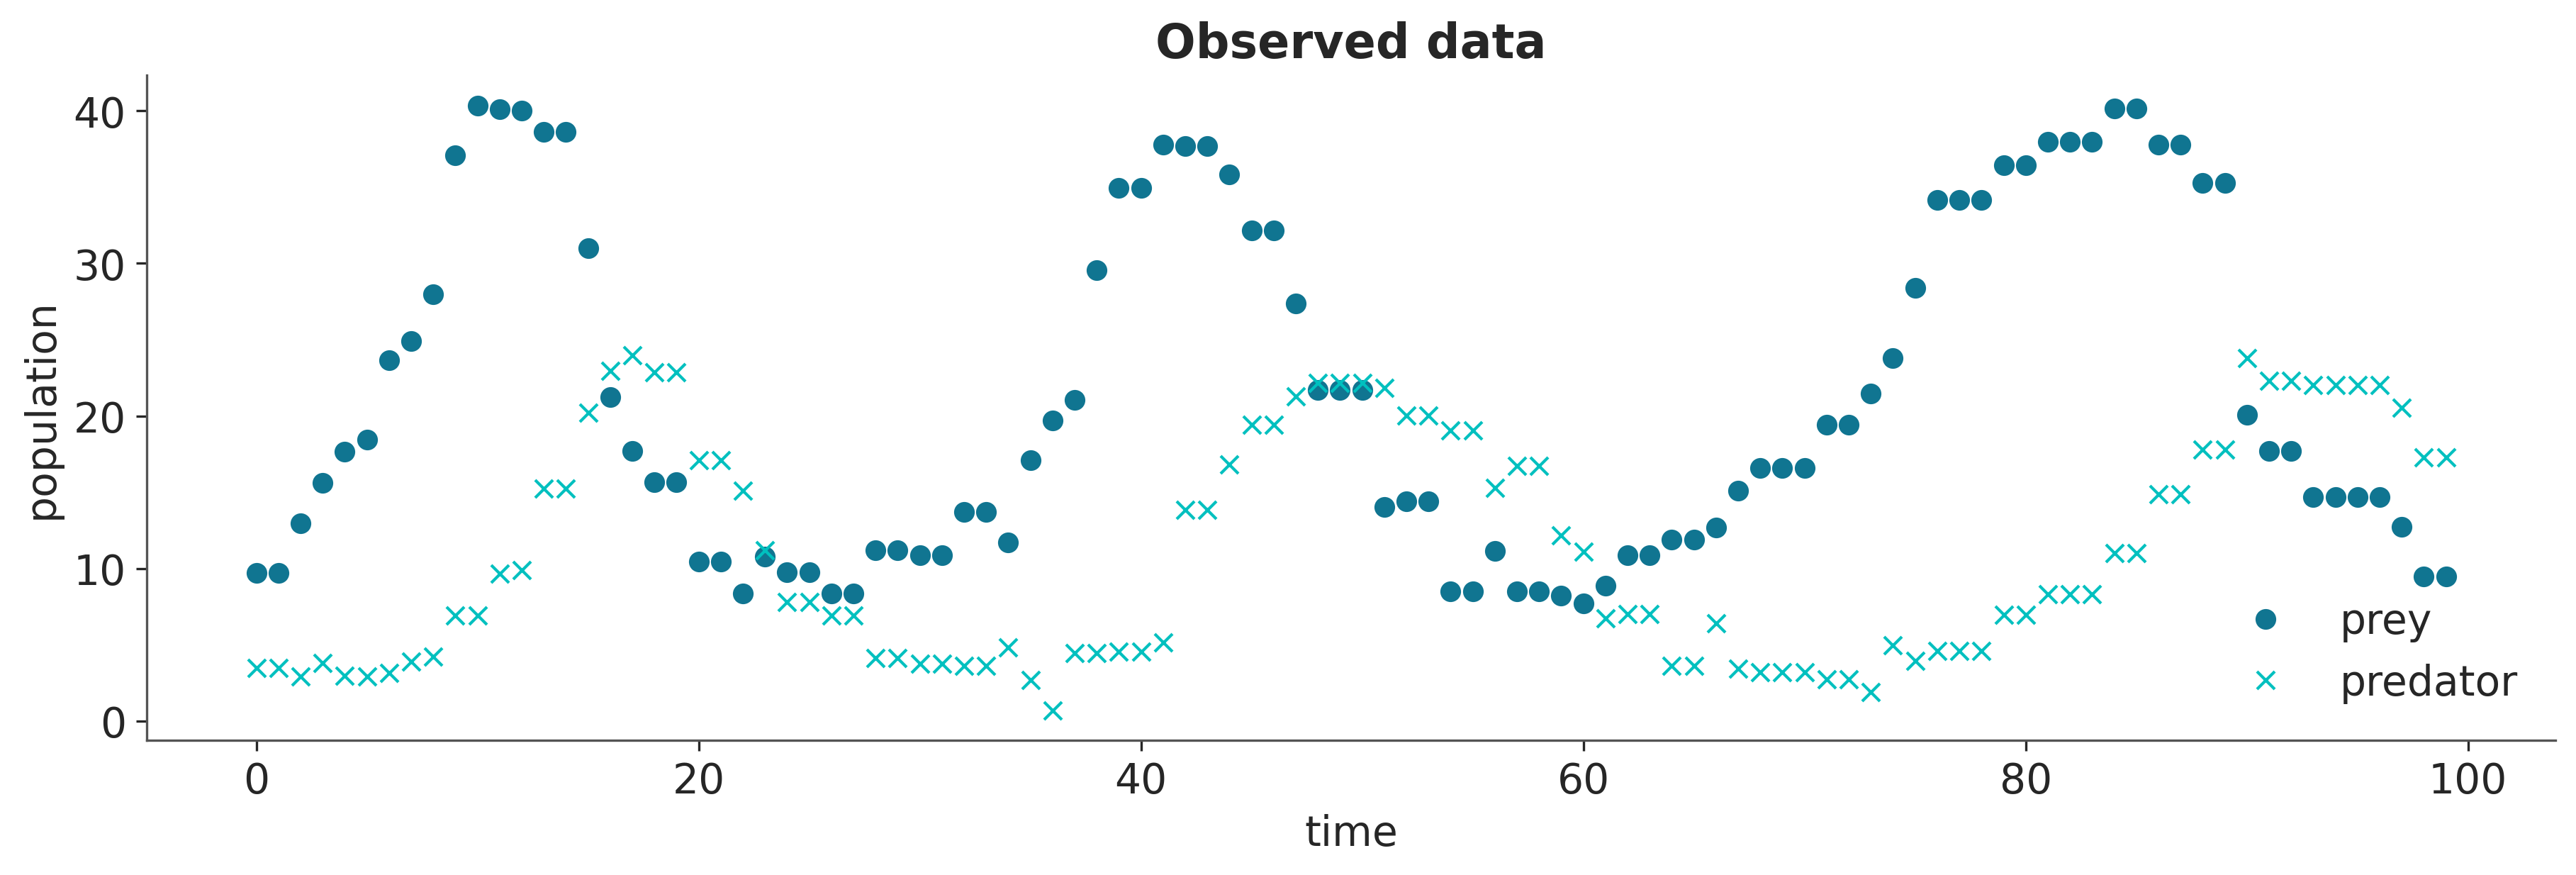

In [4]:
#| echo: false
#| output: false

# plotting observed data.
def plot_ode(state0, state1):
    _, ax = plt.subplots(figsize=(12,4))
    ax.plot(state0, 'o', label='prey')
    ax.plot(state1, 'x', label='predator')
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    ax.set_title('Observed data')
    return ax

ax = plot_ode(observed[:,0], observed[:,1])
ax.legend();

We can use the prior distribution as a proposal distribution to sample model parameters, and generate synthetic observations with the `competition_model` simulator.

In [5]:
ode_prior = tfd.JointDistributionSequential([
  tfd.LogNormal(tf.math.log(X0[0]), .25,),
  tfd.LogNormal(tf.math.log(X0[1]), .25),
  tfd.LogNormal(tf.math.log(.9), .5),
  tfd.LogNormal(tf.math.log(.09), .5),
  tfd.LogNormal(tf.math.log(1.), .5),
  tfd.LogNormal(tf.math.log(.06), .5),
])

N = 200
proposals = ode_prior.sample(N)
simulation = competition_model(*proposals)

theta = tf.stack(proposals, axis=1)
X = tf.transpose(tf.stack(simulation.states, axis=0))
X = tf.reshape(X, [-1, 200])


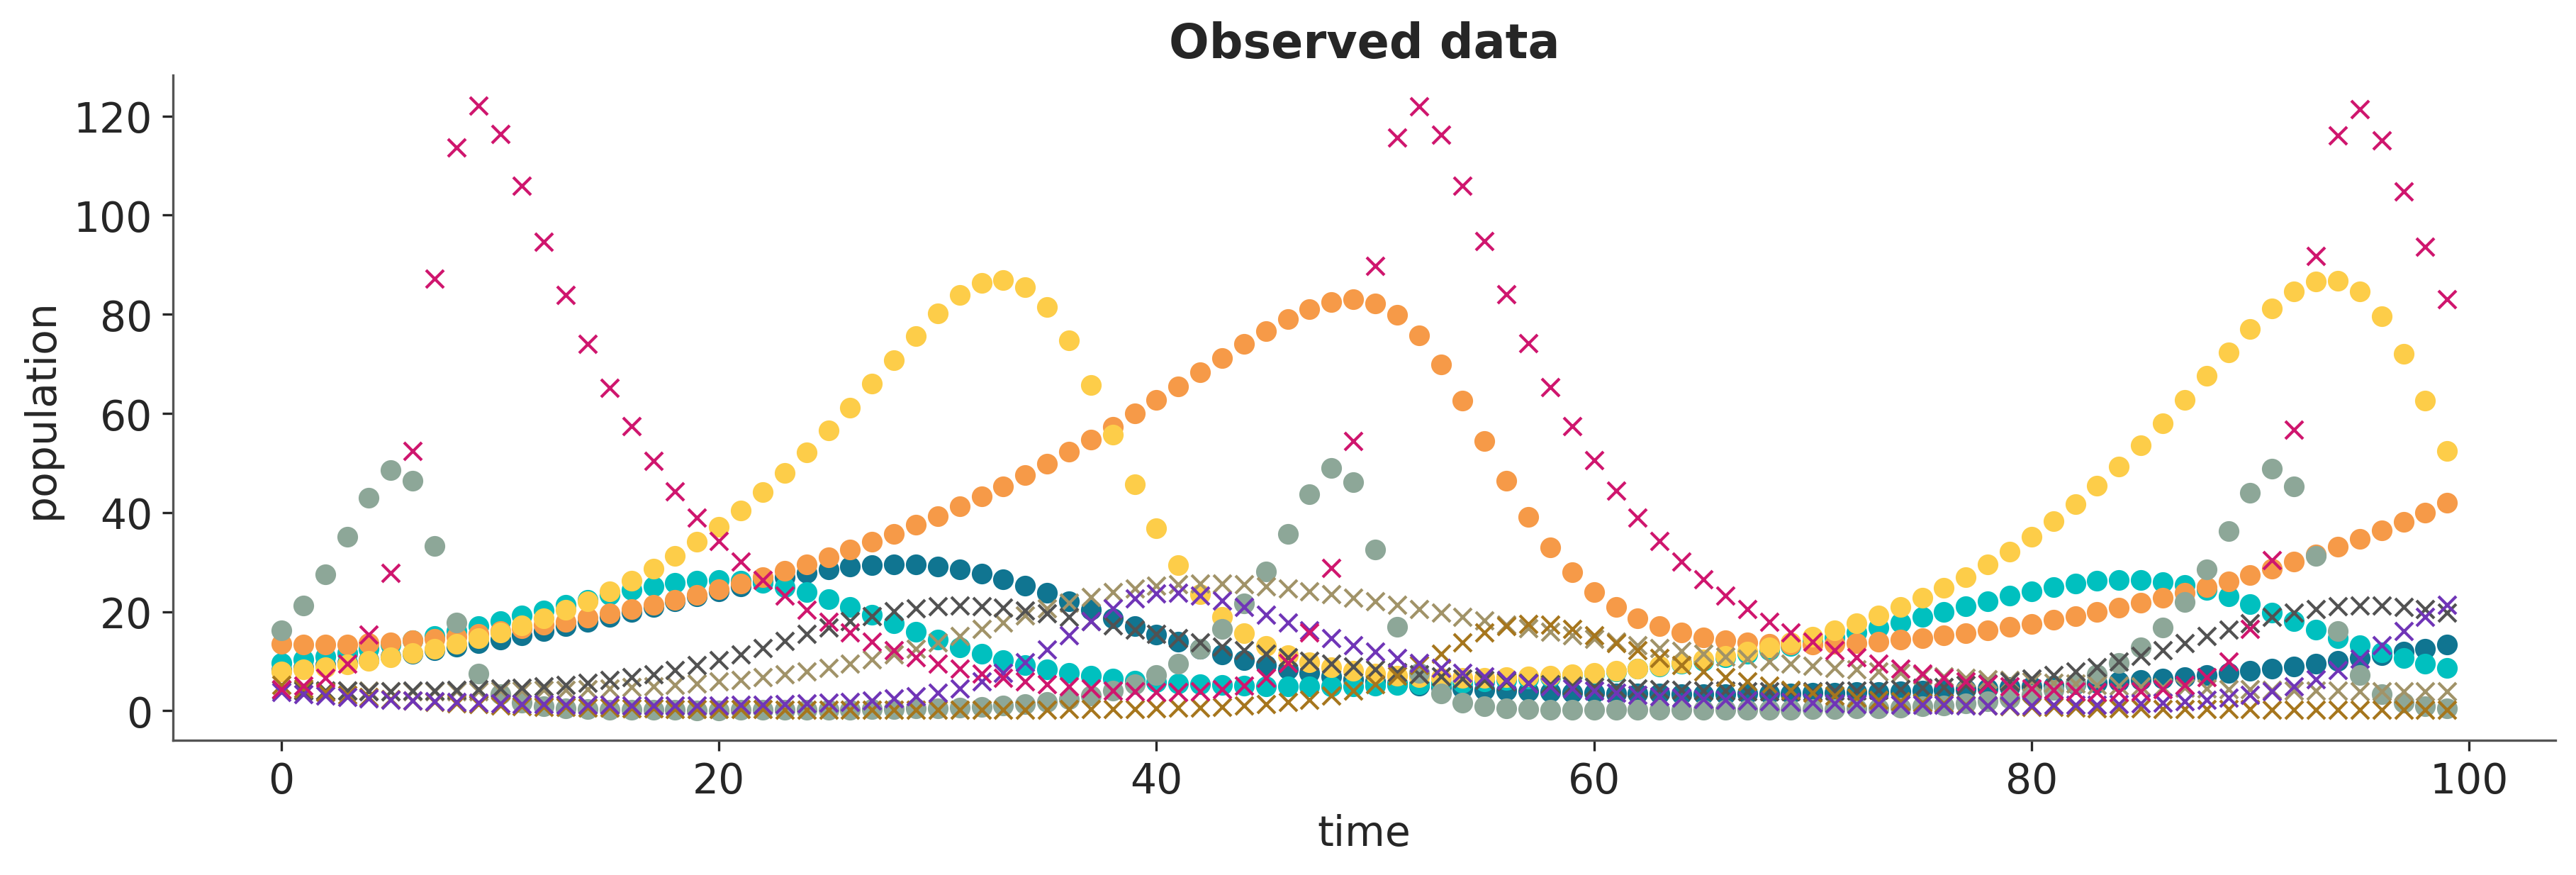

In [6]:
#| echo: false
#| output: false


result = competition_model(*ode_prior.sample(5))
ax = plot_ode(result.states[0], result.states[1])

For density estimation, TensorFlow Probability readily implements [autoregressive neural networks](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/AutoregressiveNetwork). Roughly, the idea is that a mapping $f_{nn}: \mathbb{R}^n \rightarrow \mathbb{R}^n$ defined by a dense neural network is in general not necessarily bijective, but an autoregressive condition can be enforced by applying a mask to the weights of the network, which effectively renders the restricted $f_{nn}$ bijective. This mapping can then be used to define a [masked autoregressive flow](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow) that deforms a base normal distribution into a target distribution that should approximate the simulated data points. The weights of the best fitting flow can be found by minimizing the average negative log-likelihood over the training examples through gradient descent.

Moreover, a masked autoregressive network can be defined in such a way that it accepts a conditional input, which can be provided during training, and subsequently when we sample from the resulting transformed distribution or evaluate its conditional density.

In [7]:
# Conditional density estimation with MADE.
made = tfb.AutoregressiveNetwork(
  params=2,
  hidden_units=[8, 8],
  event_shape=(X.shape[-1],),
  conditional=True,
  kernel_initializer=tfk.initializers.VarianceScaling(0.1, seed=42),
  conditional_event_shape=(theta.shape[-1],)
)

distribution = tfd.TransformedDistribution(
  distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.),
                          sample_shape=[X.shape[-1]]),
  bijector=tfb.MaskedAutoregressiveFlow(made))

# Construct and fit a model.
X_ = tfkl.Input(shape=(X.shape[-1],), dtype=tf.float32)
theta_ = tfkl.Input(shape=(theta.shape[-1],), dtype=tf.float32)
log_prob_ = distribution.log_prob(
  X_, bijector_kwargs={'conditional_input': theta_})
model = tfk.Model([X_, theta_], log_prob_)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss=lambda _, log_prob: -log_prob)

batch_size = 50




In [8]:
history = model.fit(x=[X, theta],
                    y=np.zeros((X.shape[0], 0), dtype=np.float32),
                    batch_size=batch_size,
                    epochs=2500,
                    steps_per_epoch=X.shape[0] // batch_size,
                    shuffle=True,
                    verbose=False)

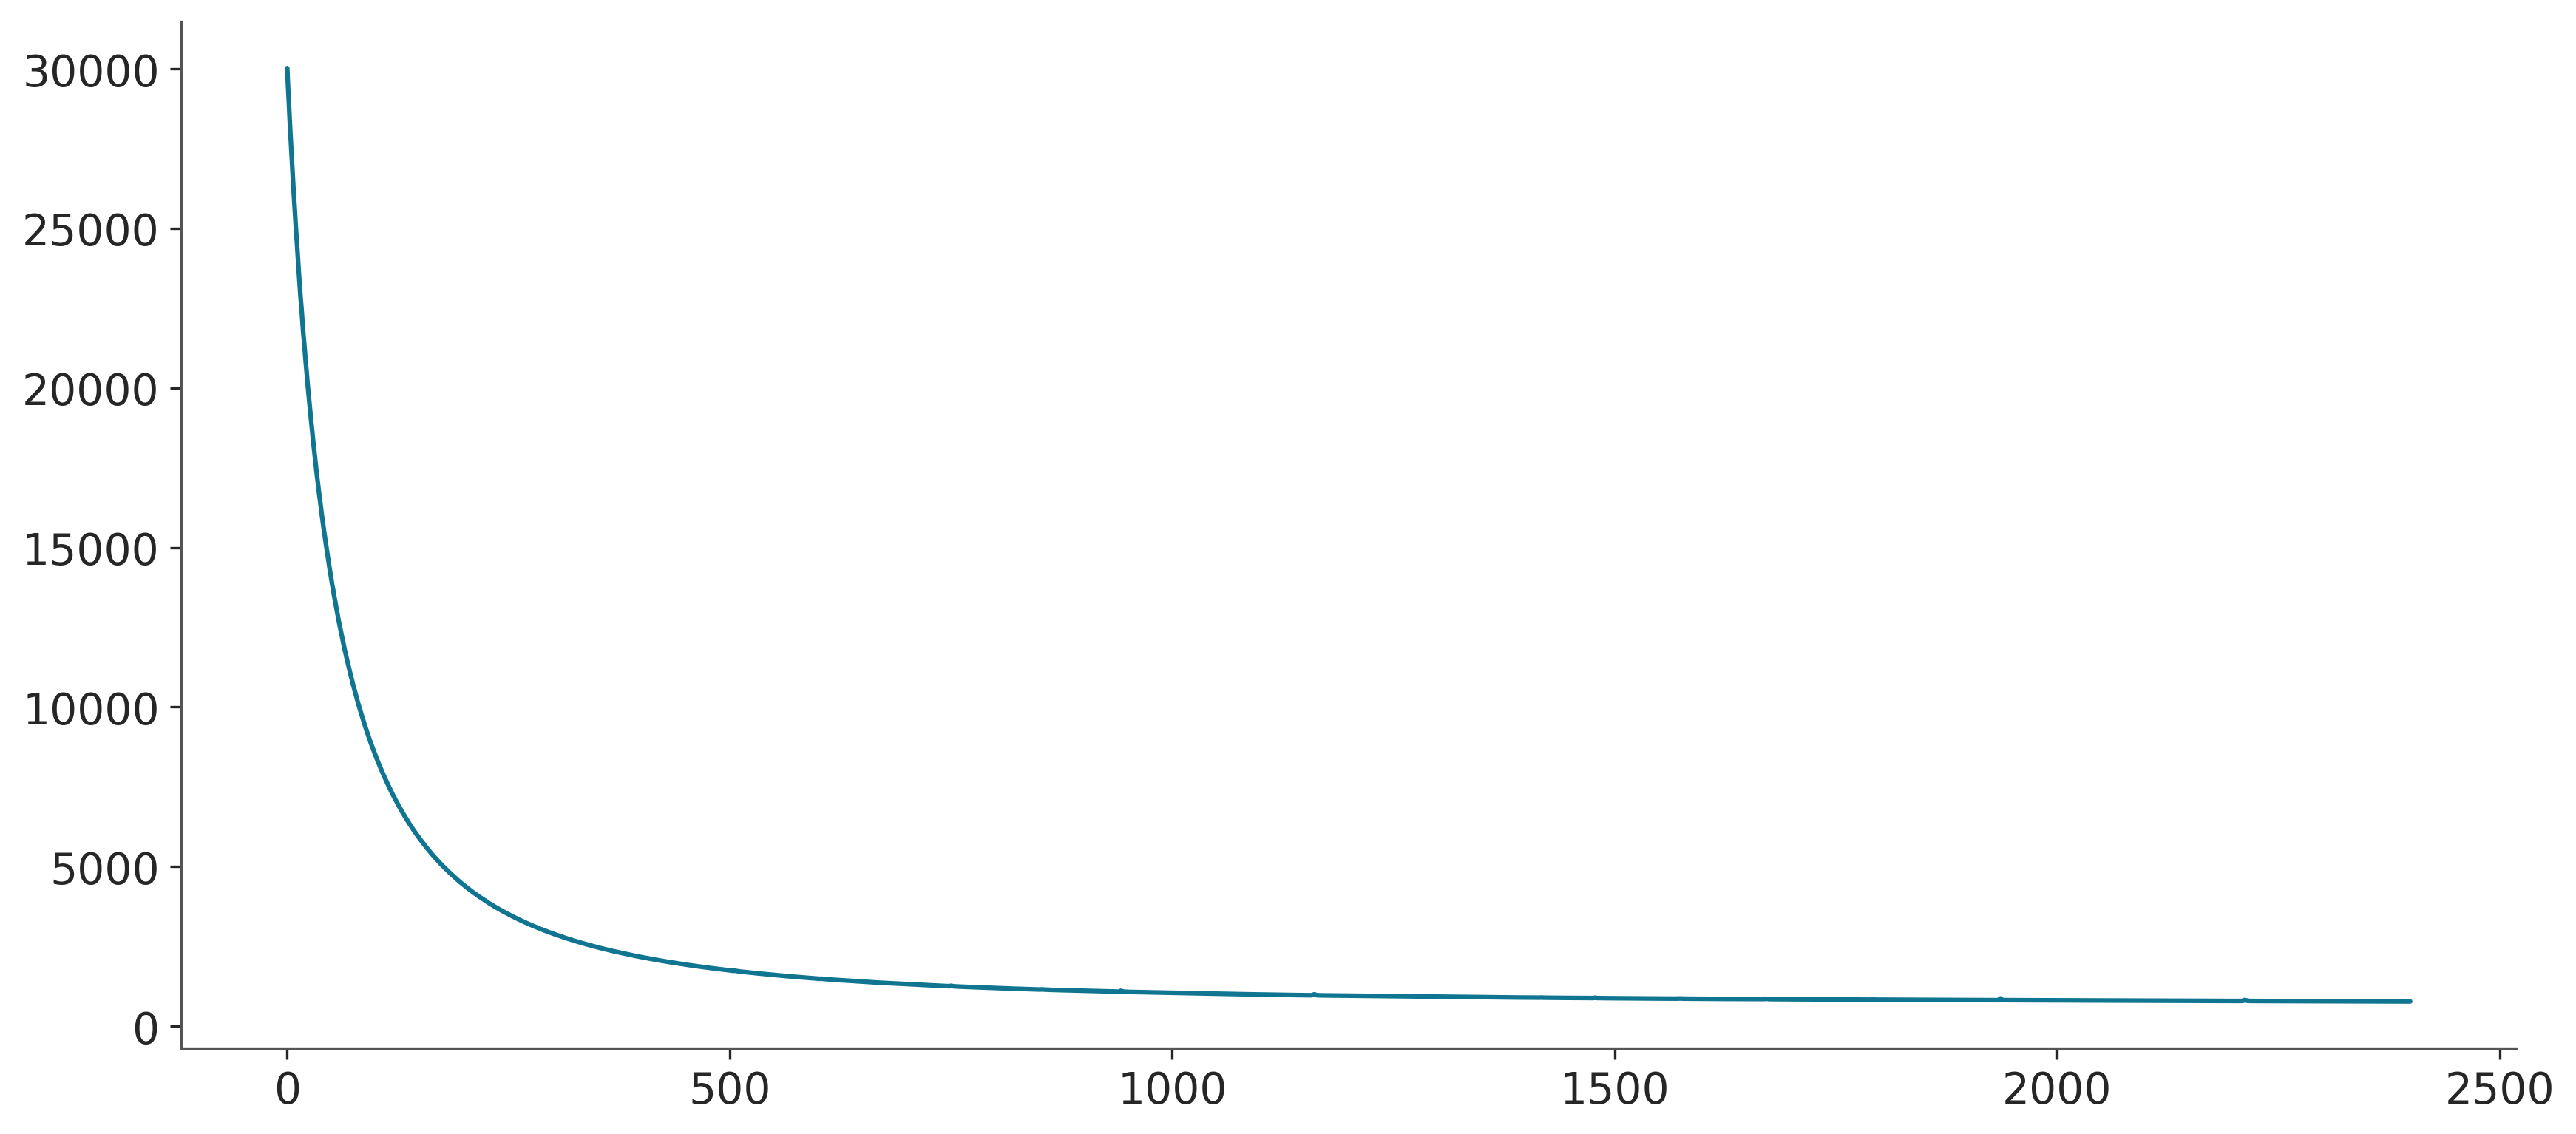

In [9]:
#| echo: false

plt.plot(history.history['loss'][100:])
plt.show()

In [10]:
#| echo: false

@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
              num_steps=500, burnin=50):

    def trace_fn(_, pkr):
        return (
            pkr.inner_results.inner_results.target_log_prob,
            pkr.inner_results.inner_results.leapfrogs_taken,
            pkr.inner_results.inner_results.has_divergence,
            pkr.inner_results.inner_results.energy,
            pkr.inner_results.inner_results.log_accept_ratio
               )

    kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=tfp.mcmc.NoUTurnSampler(
          target_log_prob_fn,
          step_size=step_size),
        bijector=unconstraining_bijectors)

    hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=burnin,
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
            inner_results=pkr.inner_results._replace(step_size=new_step_size)),
        step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
      )

    # Sampling from the chain.
    chain_state, sampler_stat = tfp.mcmc.sample_chain(
          num_results=num_steps,
          num_burnin_steps=burnin,
          current_state=init_state,
          kernel=hmc,
          trace_fn=trace_fn)
    return chain_state, sampler_stat

## Neural likelihood estimation
The key idea of the [sequential neural likelihood estimation (SNLE) algorithm](http://proceedings.mlr.press/v89/papamakarios19a/papamakarios19a.pdf) is that the estimated density function of the conditional distribution of the measurements given the parameters $\tilde p(X=X_0 \vert \theta)$ evaluated at the observed data $X_0$ is a neural estimate of the likelihood function of the model.


In [11]:
X_0 = tf.reshape(observed, (200,))

def neural_likelihood(*state):
    return distribution.log_prob(X_0,
                                 bijector_kwargs={'conditional_input': state})

It can then be combined with the prior density and used in an MCMC algorithm as the target unnormalized density to generate samples of an approximation of the posterior distribution.

In [12]:
def target_log_prob_fn(*state):
    return neural_likelihood(*state) + ode_prior.log_prob(state)

In [13]:
#| echo: false
#| output: false


step_size = [tf.cast(i, dtype=tf.float32) for i in [.1, .1, .1, .1, .1, .1]]

# bijector to map contrained parameters to real
unconstraining_bijectors = 6 * [tfb.Exp()]

init_state = list(theta[-1].numpy())

samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors, burnin=200)

2023-07-14 18:58:54.958187: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed


In [14]:
#| echo: false
#| output: false


sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}

var_name = ['x0', 'x1', 'a', 'b', 'c', 'd']
posterior = {k:v.numpy()
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

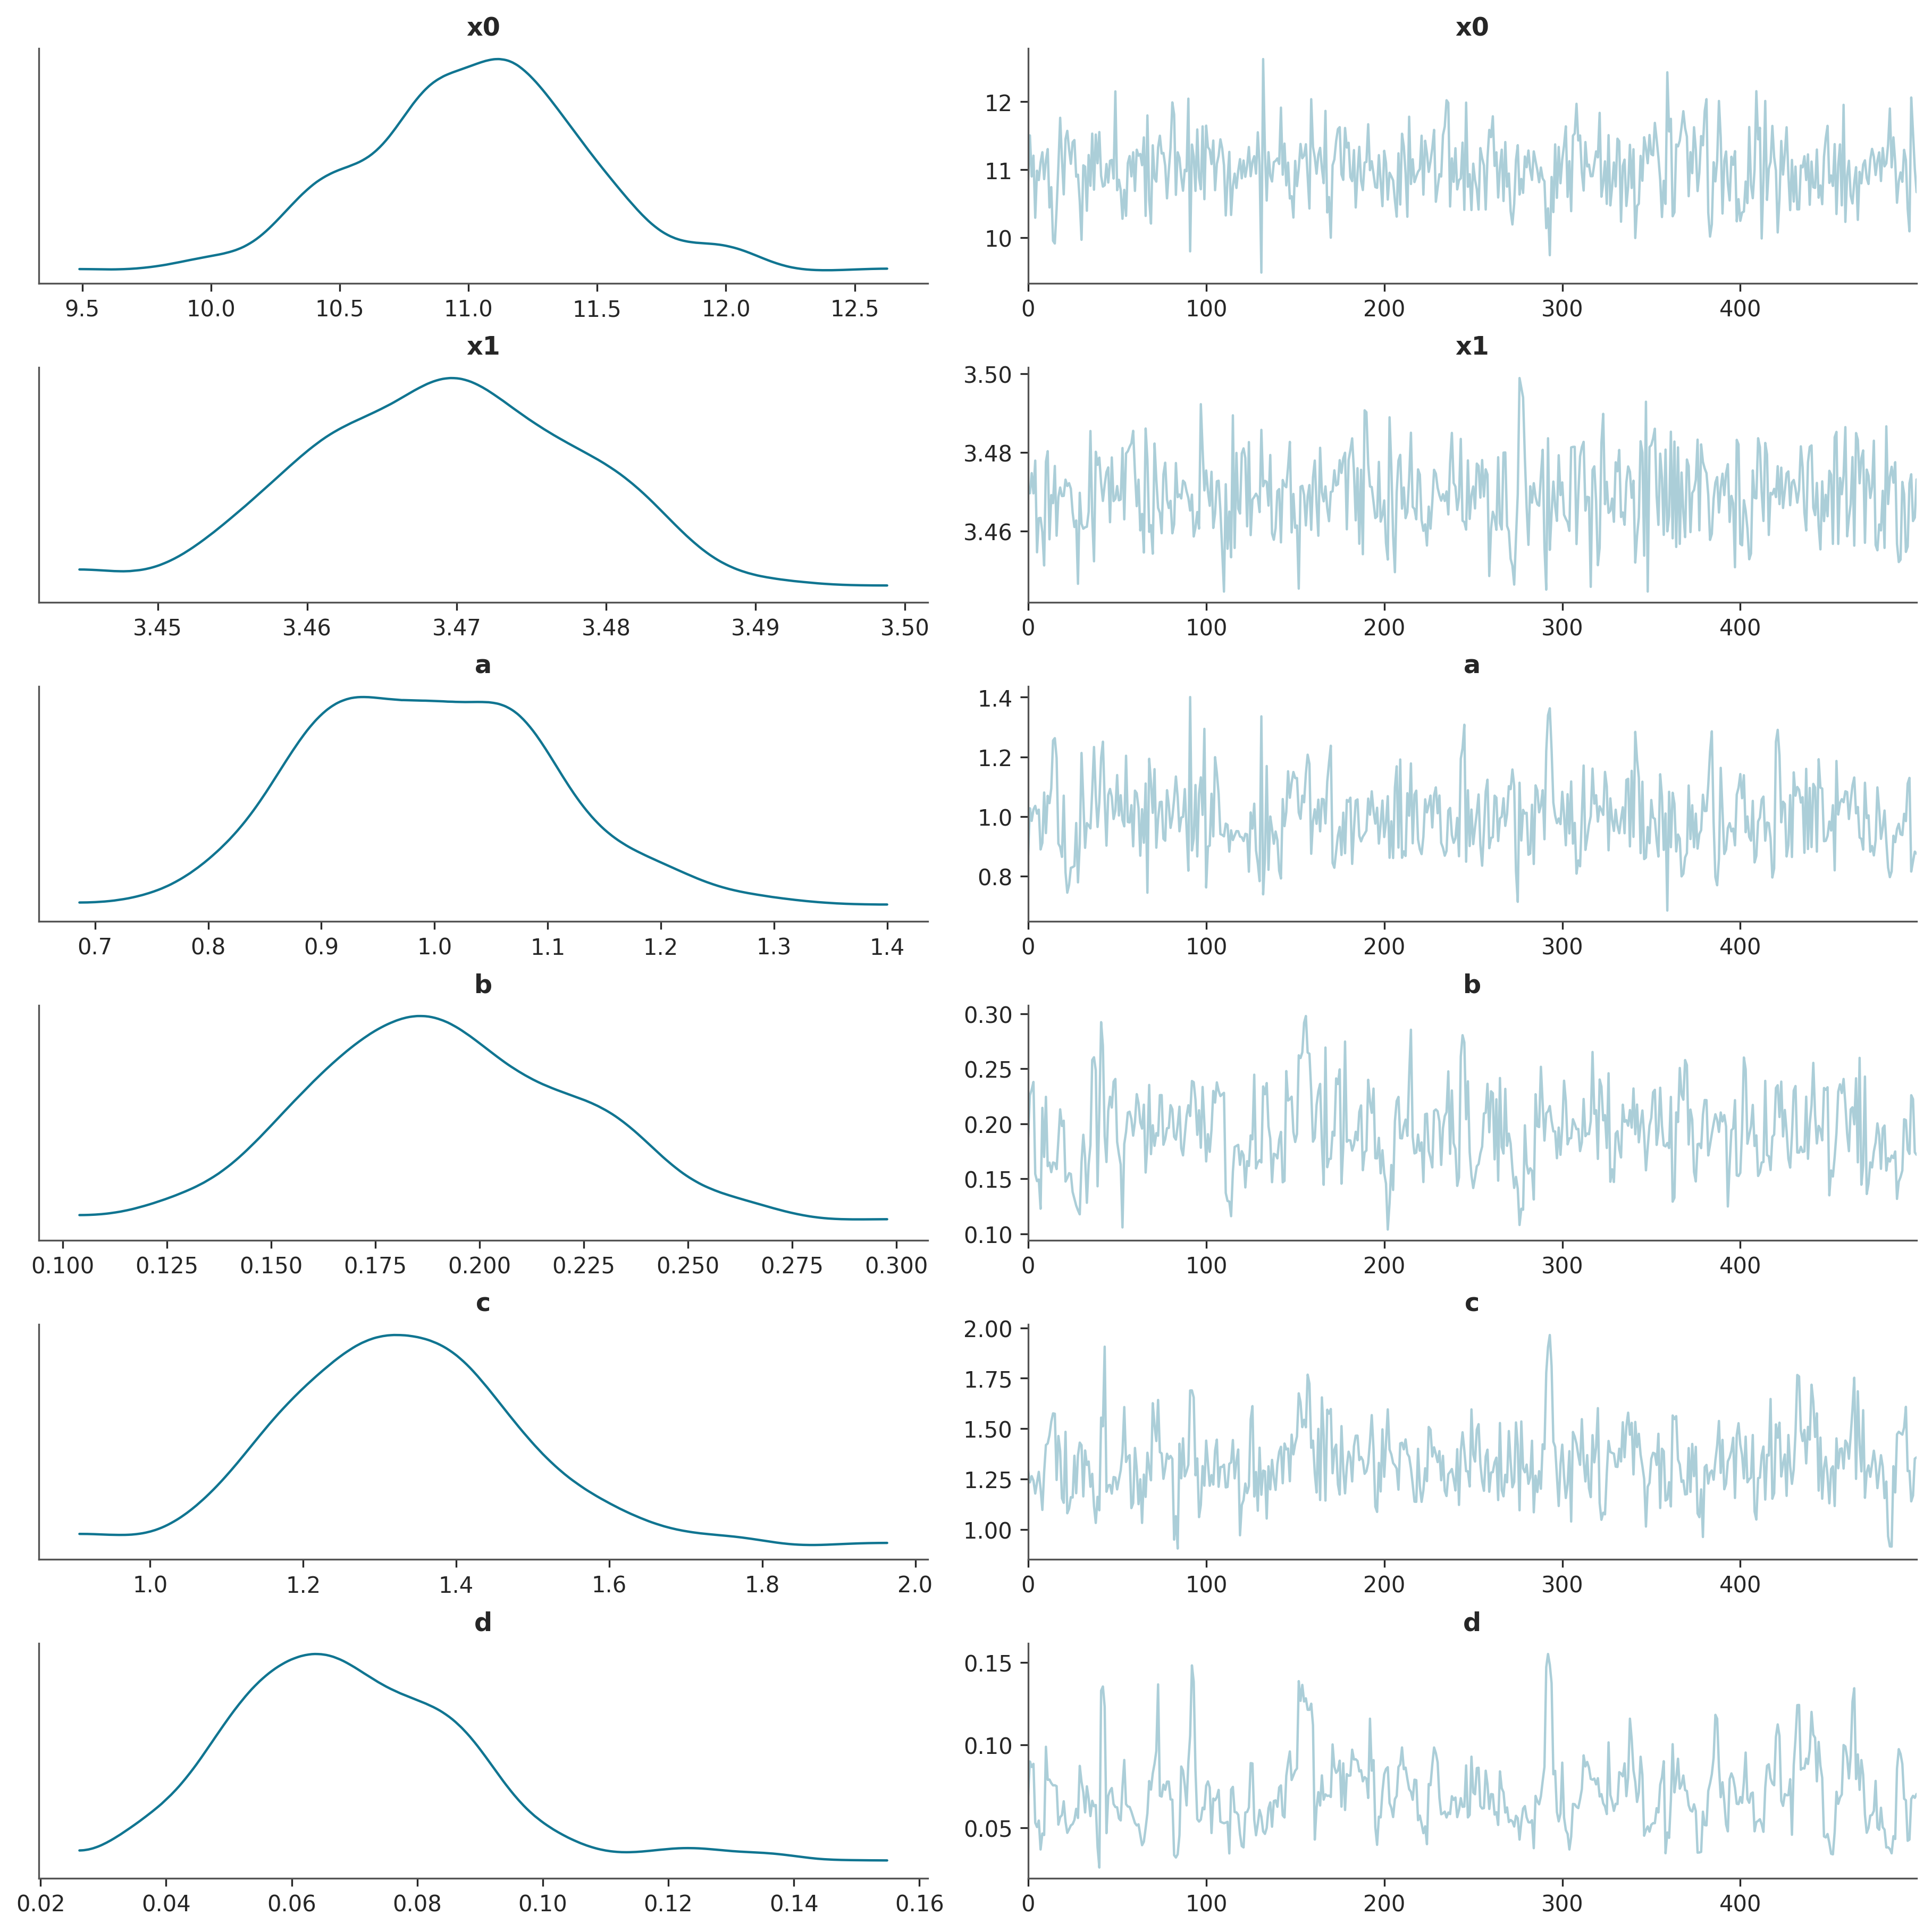

In [15]:
#| echo: false

az.plot_trace(az_trace);

Here we sampled training examples with the prior distribution as the proposal distribution for the model parameters. The problem with this approach is that the neural likelihood estimator is more accurate where the sample parameters are denser, which is not necessarily the case in the region of the actual parameter corresponding to the observation $X_0$. The SNLE algorithm addresses this issue by first sampling parameters from the prior and generating observations with the simulator model, then estimating the likelihood, and then sampling more parameters through MCMC with corresponding simulated observations, and repeating this sequence of neural model calibration and synthetic data generation a predefined number of times. At each cycle, it should generate training parameters closer to the true posterior and improve the estimation of the likelihood function.

In [ ]:
#| output: false
R = 15
N = 200

synthetic_X = X
synthetic_theta = theta

def sample_params(init_theta, size=100):
    init_state = list(init_theta.numpy())
    print('running MC chain')
    samples, _ = run_chain(
        init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
        num_steps=size, burnin=50)
    return samples

def sample_synthetic_data(param_samples):
    print('running simulation')
    simulation = competition_model(*param_samples)

    print('processing results')

    new_X = tf.reshape(tf.transpose(tf.stack(simulation.states, axis=0)),
                       [-1, 200])
    new_theta = tf.stack(param_samples, axis=1)

    return new_theta, new_X

for i in range(R):
    print(f'Step {i}')
    new_theta, new_X = sample_synthetic_data(
        sample_params(synthetic_theta[-1], size=N)
    )
    synthetic_theta = tf.concat([synthetic_theta, new_theta], axis=0)
    synthetic_X = tf.concat([synthetic_X, new_X], axis=0)

    history = model.fit(x=[synthetic_X, synthetic_theta],
                    y=np.zeros((synthetic_X.shape[0], 0),
                               dtype=np.float32),
                    batch_size=batch_size,
                    epochs=300,
                    steps_per_epoch=synthetic_X.shape[0] // batch_size,
                    shuffle=True,
                    verbose=False)

Finally we can run the MCMC algorithm one last time to generate sample of the estimated posterior distribution.

In [22]:
init_state = list(synthetic_theta[-1].numpy())

samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors, burnin=200, num_steps=2000)

In [23]:
#| echo: false

sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}

var_name = ['x0', 'x1', 'a', 'b', 'c', 'd']
posterior = {k:v.numpy()
             for k, v in zip(var_name, samples)}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

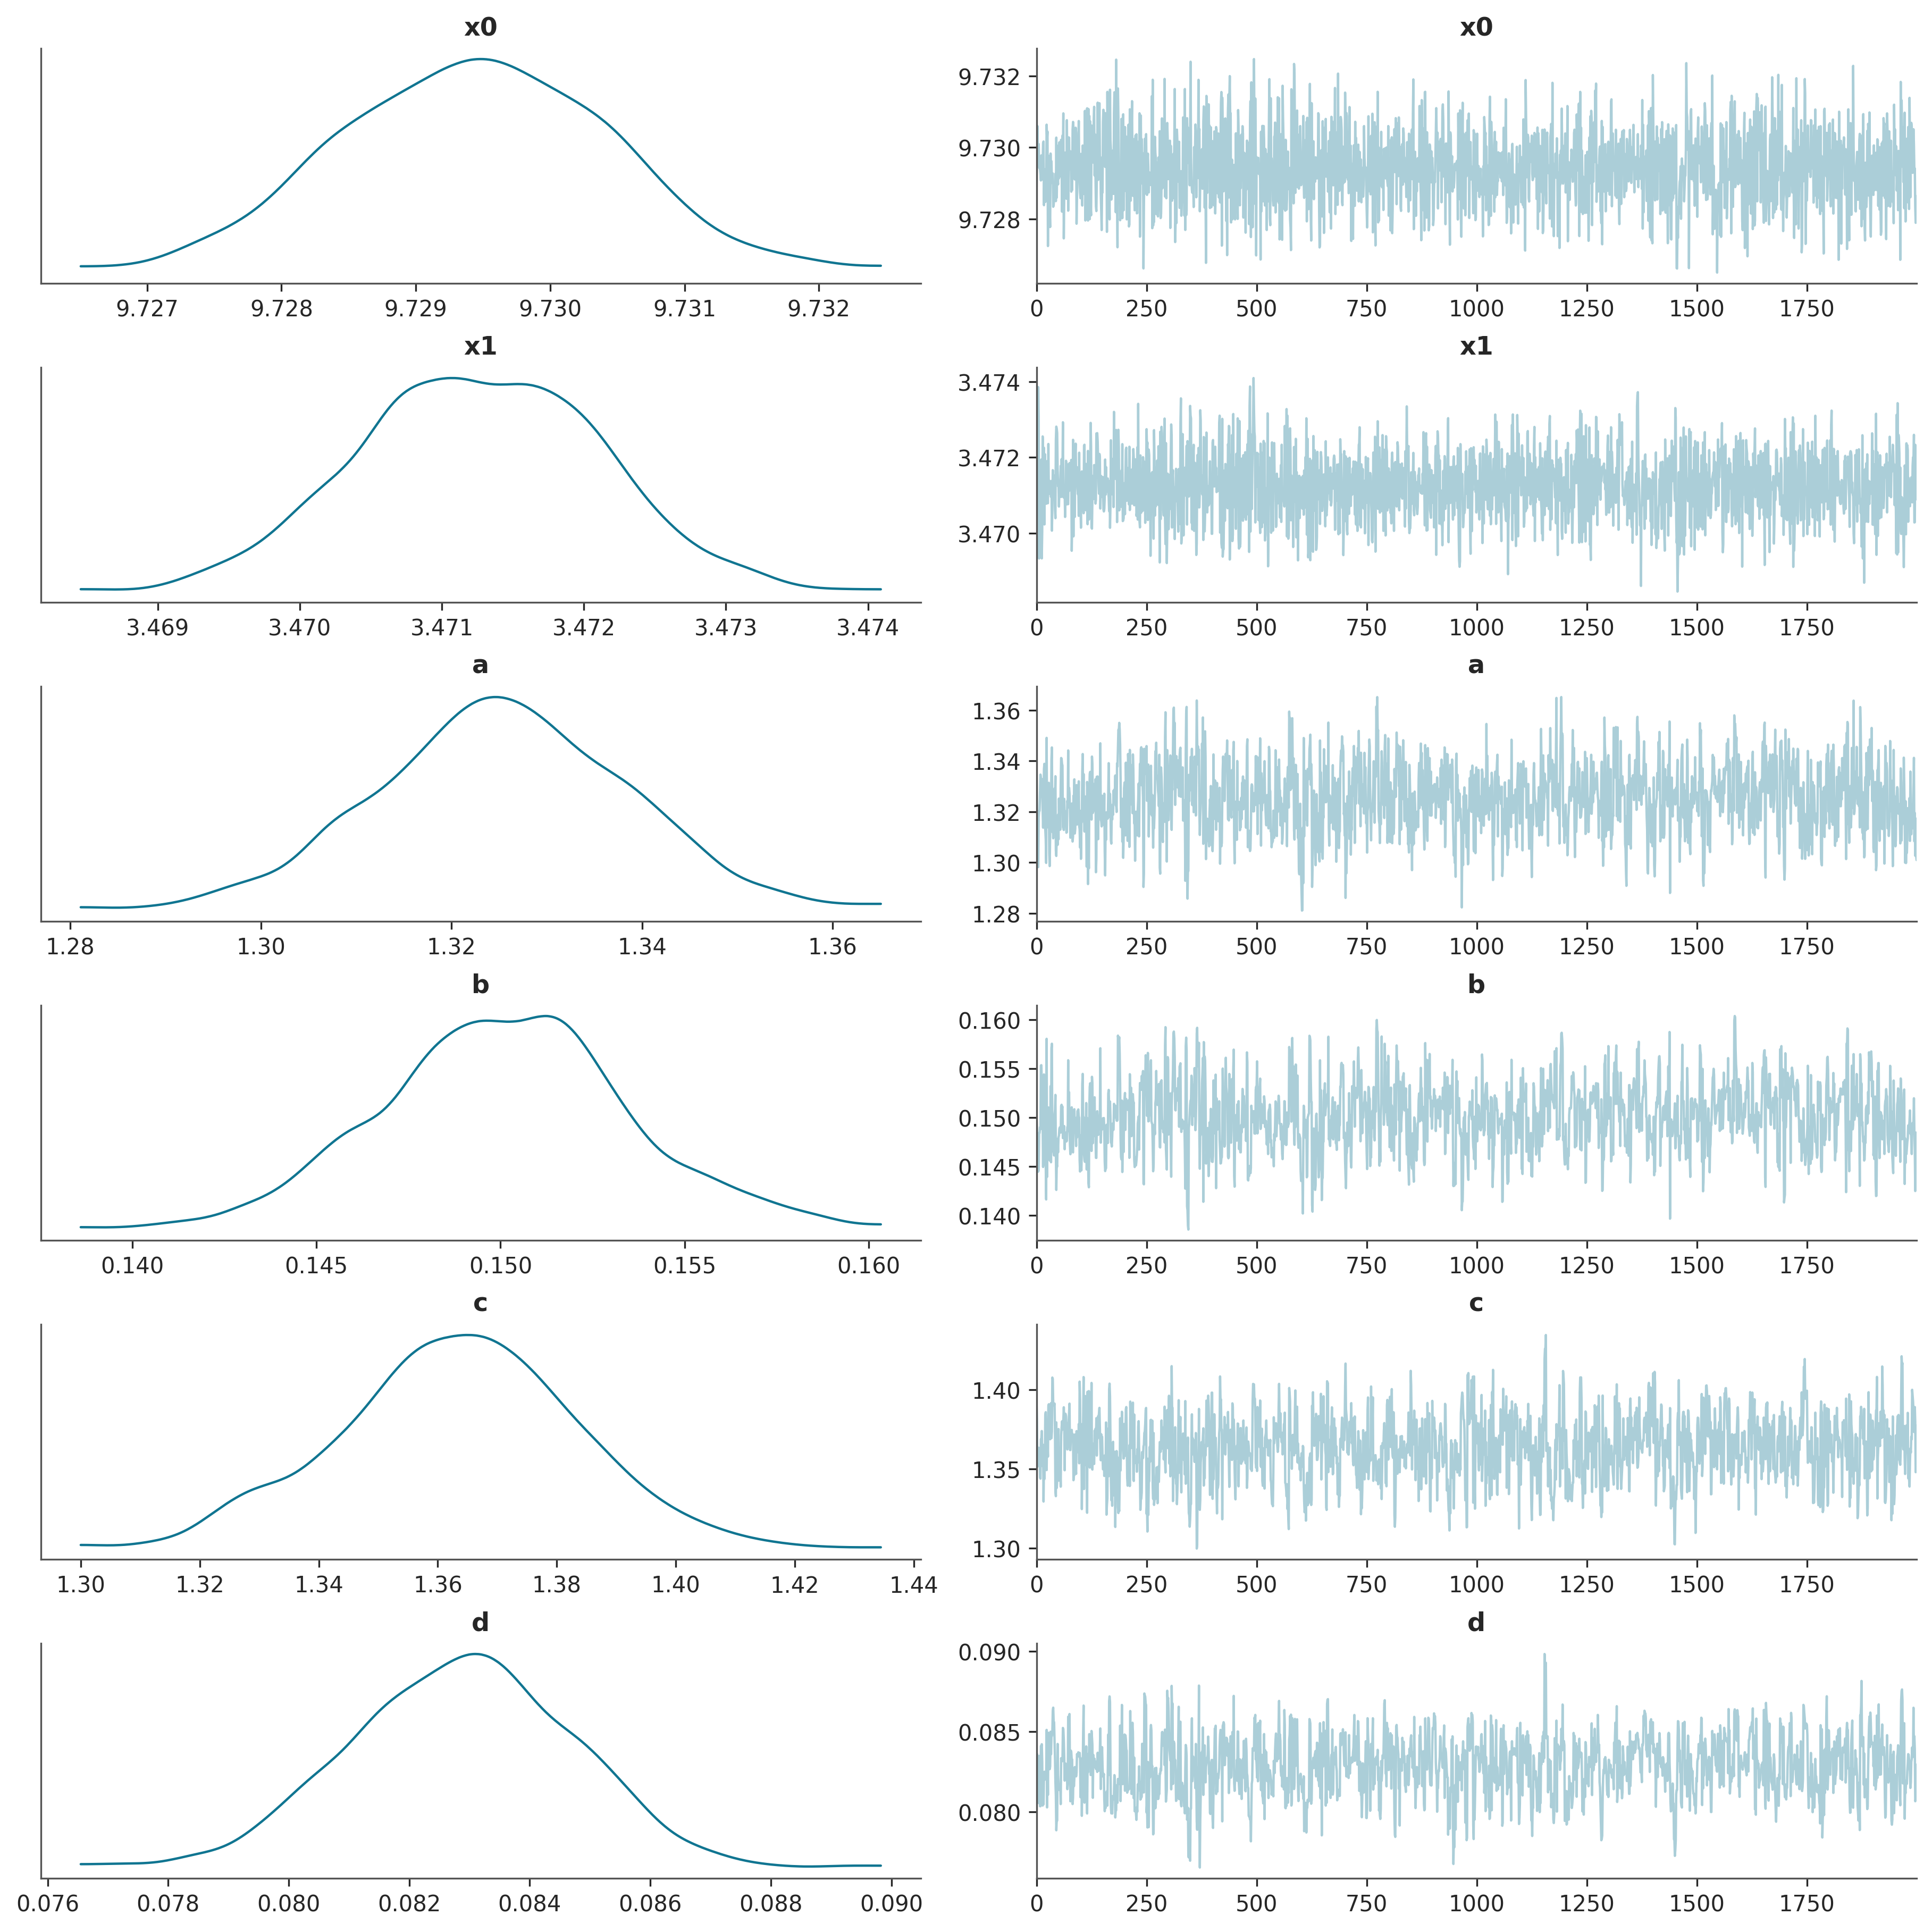

In [24]:
az.plot_trace(az_trace)
plt.show()

In [25]:
#| echo: false

posterior_predictive = tf.stack(competition_model(*samples).states)

In [26]:
#| echo: false
#| output: false

_, ax = plt.subplots(figsize=(14,6))
ax.plot(observed[:, 0], 'o', label='prey', c='C0')
ax.plot(observed[:, 1], 'x', label='predator', c='C1')
ax.plot(tf.transpose(tf.reduce_mean(posterior_predictive, axis=-1)), linewidth=2.5)
for i in np.random.randint(0, 50, 1000):
    ax.plot(posterior_predictive[0, :, i], alpha=0.05, c='C2', zorder=0)
    ax.plot(posterior_predictive[1, :, i], alpha=0.05, c='C3', zorder=0)
ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend();

## Further resources
The SNLE algorithm presented here is only one algorithm among a big family of simulation-based inference algorithms leveraging neural density estimation. Other members of this family try to estimate the posterior distribution directly, or the likelihood ratio that is used in the rejection step of MCMC samplers. They also vary in the way they define a proposal distribution for model parameters, and the way they schedule the simulation of synthetic observations, whether they do it in one go before the inference, or in different steps alternating with inference operations. The review paper "[The frontier of simulation-based inference](https://www.pnas.org/doi/10.1073/pnas.1912789117)" gives an overview of these various designs and discusses current research areas. The website [simulation-based-inference.org](https://simulation-based-inference.org/) is a great resource for applications, articles and software. The [sbi](https://www.mackelab.org/sbi/) package is a great way to get started and implements the most [common algorithms](https://www.mackelab.org/sbi/tutorial/16_implemented_methods/).